In [45]:
import torch
import numpy as np
import libsvmdata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
font =  {
            'family': 'DejaVu Sans',
            'weight': 'normal',
            'size'  :  14
        }

matplotlib.rc('font', **font)
%config InlineBackend.figure_formats = ['svg']

In [46]:
X, y = libsvmdata.fetch_libsvm('a1a')
X = torch.Tensor(X.todense())
y = torch.Tensor(y)

In [47]:
from decentralized.topologies import Topologies
from oracles.binary_svc_oracle import BinarySVC
from methods.centralized_gd import CentralizedGradientDescent
from methods.decentralized_gd import DecentralizedGradientDescent
from methods.ZOSADOM import ZOSADOM
from methods.proxnsadom import PROXNSADOM
from methods.decentralized_cs import DecentralizedCommunicationSliding

In [48]:
import pickle

def get_oracles(X, y, n, grad_type):
    result = []
    start = 0
    step = X.shape[0] // n
    for tmp in range(n):
        result.append(BinarySVC(X[start:start + step], y[start:start + step], grad_type=grad_type))
        start += step
    return result


def to_list_of_loss(logs, name=None):
    result = []
    for el in logs:
        result.append(el["loss"])
    if name is not None:
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(result, f)
    return np.array(result)

In [49]:
max_iter = 500
topology = "random"
n_nodes = 10

In [50]:
%%time
optimizer = CentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "gossip-laplacian", n_graphs=30),
    0.01,
    max_iter
)
optimizer.run(log=True)
cgd_loss = np.min(to_list_of_loss(optimizer.logs, name=f'smv_cgd_{topology}_{n_nodes}'))

CPU times: user 1.49 s, sys: 1.23 s, total: 2.72 s
Wall time: 2.41 s


In [51]:
%%time
optimizer = DecentralizedCommunicationSliding(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "gossip-laplacian", n_graphs=30),
    max_iter
)
optimizer.run(log=True)
dcs_loss = to_list_of_loss(optimizer.logs, name=f'svm_dcs_{topology}_{n_nodes}')

CPU times: user 1min 50s, sys: 1min 3s, total: 2min 54s
Wall time: 2min 26s


In [52]:
%%time
optimizer = DecentralizedGradientDescent(
    get_oracles(X, y, n_nodes, "grad"),
    Topologies(n_nodes, topology, "mixing-laplacian",  n_graphs=30),
    0.1,
    max_iter
)
optimizer.run(log=True)
dgd_loss = to_list_of_loss(optimizer.logs, name=f'smv_DGD_{topology}_{n_nodes}')

CPU times: user 1.44 s, sys: 1.12 s, total: 2.55 s
Wall time: 2.09 s


In [53]:
%%time
topologies = Topologies(n_nodes, topology, "gossip-laplacian",  n_graphs=30)
optimizer = ZOSADOM(
        oracles=get_oracles(X,y , n_nodes, "grad"),
        topology=topologies,
        max_iter=max_iter,
    )

optimizer.run(log=True)
zosadom_loss = to_list_of_loss(optimizer.logs, name=f'svm_zosadom_{topology}_{n_nodes}')

CPU times: user 1.8 s, sys: 1.19 s, total: 2.99 s
Wall time: 2.51 s


In [54]:
%%time
topologies = Topologies(n_nodes, topology, "gossip-laplacian",  n_graphs=30)
reg = 0.1
chi = topologies.chi

optimizer = PROXNSADOM(
        oracles=get_oracles(X,y , n_nodes, "grad"),
        topology=topologies,
        max_iter=max_iter,
        eta=1 / (64 * reg * chi ** 2),
        theta=reg / (16 * chi ** 2),
        r=reg,
        gamma=reg / 2,
        saddle_lr=2e-2
    )

optimizer.run(log=True, disable_tqdm=False)
proxnsadom_loss = to_list_of_loss(optimizer.logs, name=f'svm_proxnsadom_{topology}_{n_nodes}')


  0%|          | 0/500 [00:00<?, ?it/s]

inner problem gradient: norm 0.000000, max 0.000010
xnorm_diff tensor(0.0138) ynorm_diff tensor(0.0027)
consensus:  tensor(0.0004)
{'loss': 1.736984133720398, 'losses': [1.7374114990234375, 1.7405288219451904, 1.7341206073760986, 1.737190842628479, 1.7361335754394531, 1.7408406734466553, 1.7404228448867798, 1.729875922203064, 1.7376493215560913, 1.7356672286987305], 'eta': 0.0013694049831267003, 'theta': 5.477619932506802e-05, 'gamma': 0.05, 'a': 1.0}
inner problem gradient: norm 0.000000, max 0.000017
xnorm_diff tensor(0.0224) ynorm_diff tensor(0.0044)
consensus:  tensor(0.0010)
{'loss': 1.7160803198814392, 'losses': [1.7162882089614868, 1.719888687133789, 1.7131426334381104, 1.7157119512557983, 1.7156751155853271, 1.7197948694229126, 1.7196118831634521, 1.7093231678009033, 1.716909408569336, 1.7144572734832764], 'eta': 0.0013694049831267003, 'theta': 5.477619932506802e-05, 'gamma': 0.05, 'a': 1.618033988749895}
inner problem gradient: norm 0.000000, max 0.000008
xnorm_diff tensor(0.0

In [55]:
f_star = min(map(np.min, [dcs_loss,dgd_loss, zosadom_loss, proxnsadom_loss]))
f_star

1.002312421798706

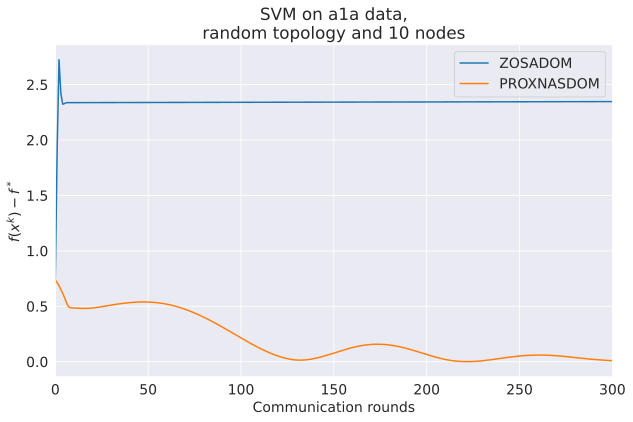

In [61]:
plt.figure(figsize=(10,6)) 
# plt.yscale("log")
plt.xlim([0,300])
# plt.plot(np.arange(max_iter + 1), dcs_loss - f_star, label="Decentralized CS")
# plt.plot(np.arange(max_iter + 1), dgd_loss - f_star, label="Decentralized GD")
plt.plot(np.arange(max_iter + 1), zosadom_loss - f_star, label="ZOSADOM")
plt.plot(np.arange(max_iter), proxnsadom_loss - f_star, label="PROXNASDOM")
plt.title(r"SVM on a1a data," + f"\n{topology} topology and {n_nodes} nodes")
plt.xlabel("Communication rounds")
plt.ylabel(r"$f(x^k) - f^*$")
plt.legend()


plt.savefig(f"img/smv_a1a_{topology}_{n_nodes}_zosadom.svg")